# Dataset

In [1]:
!pip install --quiet tensorflow
!pip install --quiet tensorflow_datasets

In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl

monet2photo = tfds.load('cycle_gan/monet2photo')

2024-04-06 00:36:33.295526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 00:36:33.295564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 00:36:33.296708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 00:36:33.303130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 00:36:34.230761: W tensorflow/comp

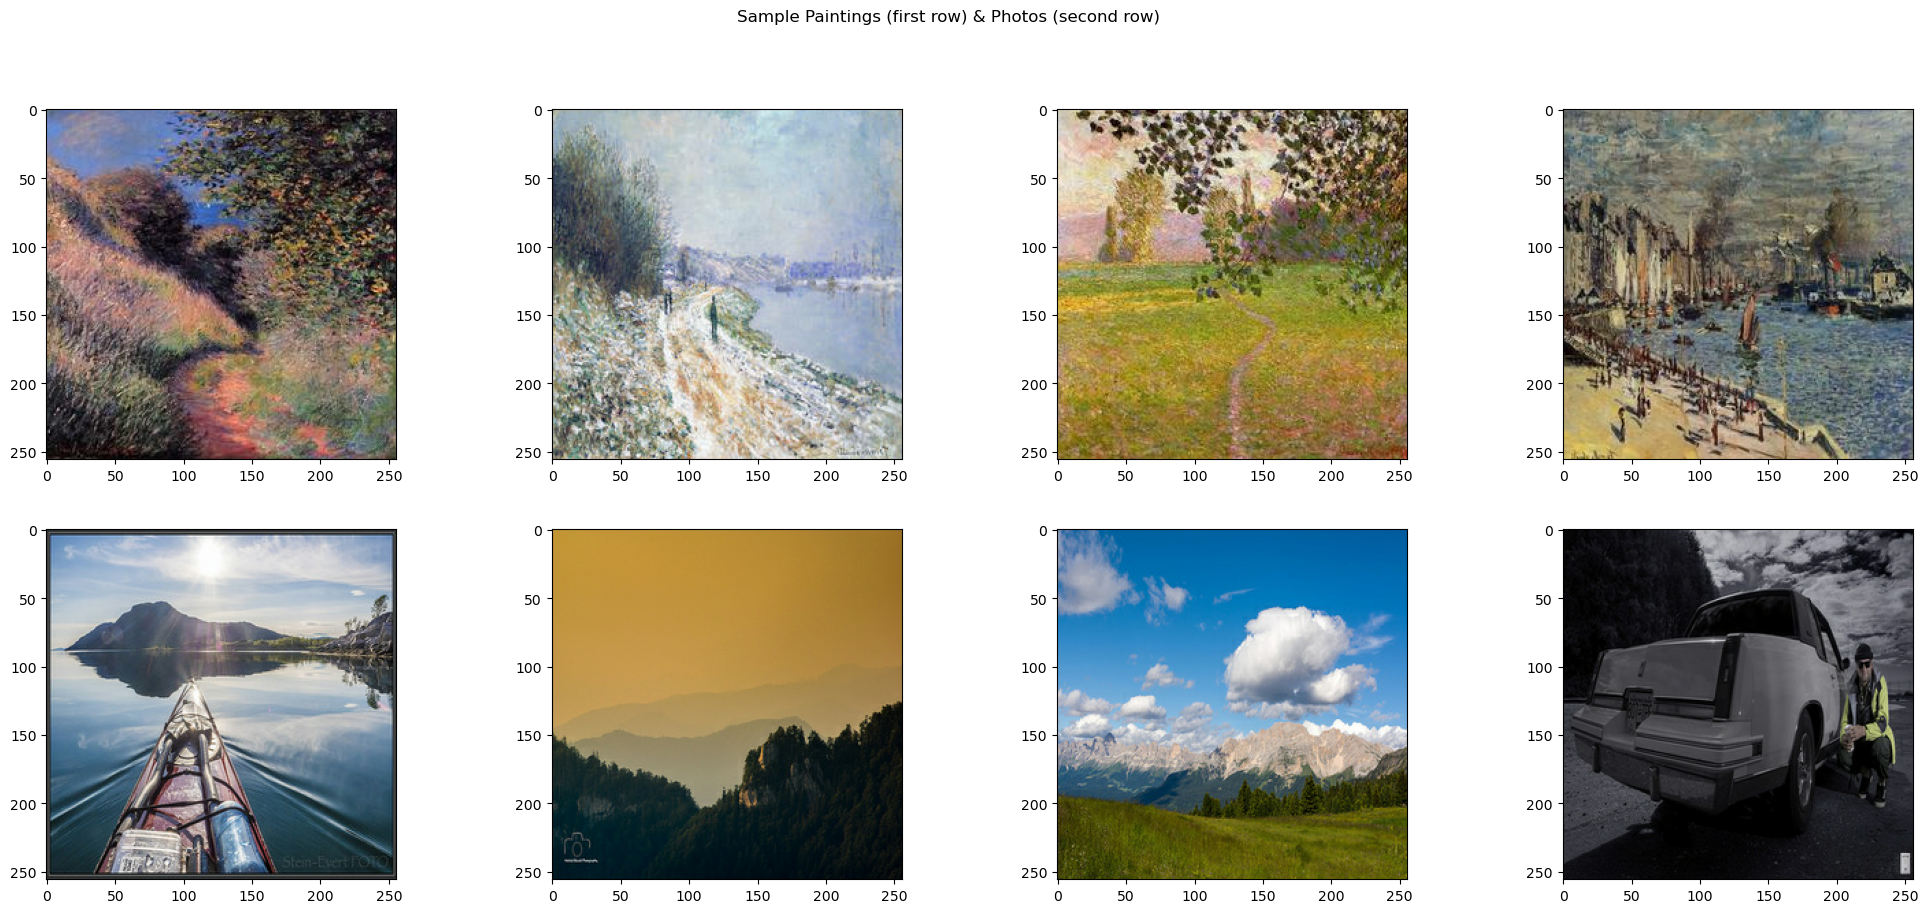

In [3]:
# Display sample images
num_imgs = 4
fig, axs = plt.subplots(2, num_imgs, figsize=(25, 10))
fig.suptitle('Sample Paintings (first row) & Photos (second row)')

for i, img in enumerate(monet2photo['trainA'].take(num_imgs)):
  axs[0][i].imshow(img['image'])
for i, img in enumerate(monet2photo['trainB'].take(num_imgs)):
  axs[1][i].imshow(img['image'])

plt.show()

### Custom Dataset Class

In [4]:
import torch
import torch.utils.data as data
import numpy as np

class PairedDataset(data.Dataset):
  '''
  Combines two TensorFlow image datasets into a PyTorch dataset for use with a
  Lightning trainer for a CycleGAN model. Labels are ignored since they are not
  necessary for a CycleGAN. The datasets are paired so that each __getitem__
  call returns one image from each set. If one dataset is larger than the other,
  indices greater than the smaller set's length will pair a random image from
  the smaller set with the corresponding index of the larger set.
  '''

  def __init__(self, dataset1, dataset2):
    self.ds1_len = len(dataset1)
    self.ds2_len = len(dataset2)
    self.ds1 = np.empty(self.ds1_len, dtype=object)
    self.ds2 = np.empty(self.ds2_len, dtype=object)
    for i, image in enumerate(dataset1):
      self.ds1[i] = torch.tensor(np.moveaxis(image['image'], -1, 0), dtype=torch.float32) / 255
    for i, image in enumerate(dataset2):
      self.ds2[i] = torch.tensor(np.moveaxis(image['image'], -1, 0), dtype=torch.float32) / 255

  def __len__(self):
    return max(len(self.ds1), len(self.ds2))

  def __getitem__(self, i):
    i1 = i if i < self.ds1_len else np.random.randint(self.ds1_len)
    i2 = i if i < self.ds2_len else np.random.randint(self.ds2_len)
    return (self.ds1[i1], self.ds2[i2])

### Dataloaders

In [5]:
m2p_train_dataset = PairedDataset(monet2photo['trainA'], monet2photo['trainB'])
m2p_test_dataset  = PairedDataset(monet2photo['testA'],  monet2photo['testB'])
monet2photo = None

m2p_train_loader = data.DataLoader(m2p_train_dataset, batch_size=1, num_workers=7)
m2p_test_loader  = data.DataLoader(m2p_test_dataset, batch_size=1, num_workers=7)

# Model

In [6]:
!pip install --quiet lightning

In [7]:
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
import lightning as L
import itertools

### Generator

In [8]:
class Generator(nn.Module):
  '''Generator netowrk for a generative adversarial network.'''

  def __init__(self, resnet_layers=3):
    '''
    Parameters
    ----------
    resnet_layers : int, default: 3
      Number of residual convolution blocks.
    '''

    super().__init__()

    channels = 64
    modules = [
      nn.Conv2d(3, channels, kernel_size=7, padding=3, padding_mode='reflect'),
      nn.BatchNorm2d(channels),
      nn.ReLU(True),
      nn.Conv2d(channels, 2*channels, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(2*channels),
      nn.ReLU(True),
      nn.Conv2d(2*channels, 4*channels, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(4*channels),
      nn.ReLU(True)
    ]

    modules += [ResidualBlock(4*channels) for i in range(resnet_layers)]

    modules += [
      nn.ConvTranspose2d(4*channels, 2*channels, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(2*channels),
      nn.ReLU(True),
      nn.ConvTranspose2d(2*channels, channels, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(channels),
      nn.ReLU(True),
      nn.Conv2d(channels, 3, kernel_size=7, padding=3, padding_mode='reflect'),
      nn.Tanh()
    ]

    self.model = nn.Sequential(*modules)

  def forward(self, x):
    return self.model(x)


class ResidualBlock(nn.Module):
  '''Residual network block for a GAN generator.'''

  def __init__(self, channels):
    '''
    Parameters
    ----------
    channels : int
      Number of channels for convolution operations.
    '''

    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
      nn.BatchNorm2d(channels),
      nn.ReLU(True),
      nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
      nn.BatchNorm2d(channels)
    )

  def forward(self, x):
    return x + self.model(x)  # Skip connection

### Discriminator

In [9]:
class Discriminator(nn.Module):
  '''PatchGAN discriminator network for a generative adversarial network.'''

  def __init__(self, layers=3):
    '''
    Parameters
    ----------
    layers : int, default: 3
      Number of intermediate convolution layers.
    '''

    super().__init__()

    channels = 64
    modules = [
      nn.Conv2d(3, channels, kernel_size=4, stride=2, padding=1),
      nn.ReLU(True)
    ]

    out_channels = min(2*channels, 512)
    for i in range(layers-1):
      modules += [
        nn.Conv2d(channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
      ]
      channels = out_channels
      out_channels = min(2*channels, 512)

    modules += [
      nn.Conv2d(channels, out_channels, kernel_size=4, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(True),
      nn.Conv2d(out_channels, 1, kernel_size=4, padding=1)
    ]

    self.model = nn.Sequential(*modules)

  def forward(self, x):
    return self.model(x)

### CycleGAN

In [10]:
class CycleGAN(L.LightningModule):
  '''
  CycleGAN model for artistic style transfer between 2 image domains.

  Attributes
  ----------
  G : Generator
    Network that generates an image with the style of domain Y based on an image
    from domain X.
  F : Generator
    Network that generates an image with the style of domain X based on an image
    from domain Y.
  Dx : Discriminator
    Network that determines if an image came from domain X.
  Dy : Discriminator
    Network that determines if an image came from domain Y.

  Methods
  -------
  test_G(image)
    Returns the output of generator G for a single given image.
  test_F(image)
    Returns the output of generator F for a single given image.
  '''

  def __init__(self, gen_resnet_layers=6, dis_conv_layers=3, use_checkpointing=True):
    '''
    Parameters
    ----------
    gen_resnet_layers : int, default: 6
      Number of residual layers in the generators.
    dis_conv_layers : int, default: 3
      Number of intermediate convolution layers in the discriminators.
    use_checkpointing : bool, default: True
      Determines if checkpointing is used on forward passes of generators during
      training; if true, reduces memory usage in exchange for more computations.
    '''

    super().__init__()
    self.automatic_optimization = False
    self.use_checkpointing = use_checkpointing

    self.G  = Generator(gen_resnet_layers)
    self.F  = Generator(gen_resnet_layers)
    self.Dx = Discriminator(dis_conv_layers)
    self.Dy = Discriminator(dis_conv_layers)

  def configure_optimizers(self):
    gen_optimizer = optim.Adam(itertools.chain(self.G.parameters(), self.F.parameters()))
    dis_optimizer = optim.Adam(itertools.chain(self.Dx.parameters(), self.Dy.parameters()))
    return [gen_optimizer, dis_optimizer]

  def test_G(self, image):
    with torch.no_grad():
      image = torch.tensor(image[None,:,:,:])
      if next(self.G.parameters()).is_cuda:
        image = image.cuda()
      return self.G(image).cpu().numpy()

  def test_F(self, image):
    with torch.no_grad():
      image = torch.tensor(image[None,:,:,:])
      if next(self.F.parameters()).is_cuda:
        image = image.cuda()
      return self.F(image).cpu().numpy()


  def training_step(self, batch, batch_idx):
    gen_optimizer, dis_optimizer = self.optimizers()
    real_x, real_y = batch

    # Train generators
    gen_optimizer.zero_grad()

    if self.use_checkpointing:
      fake_y = checkpoint(self.G, real_x, preserve_rng_state=False, use_reentrant=False)
      fake_x = checkpoint(self.F, real_y, preserve_rng_state=False, use_reentrant=False)
      rec_y  = checkpoint(self.G, fake_x, preserve_rng_state=False, use_reentrant=False)
      rec_x  = checkpoint(self.F, fake_y, preserve_rng_state=False, use_reentrant=False)
      id_y   = checkpoint(self.G, real_y, preserve_rng_state=False, use_reentrant=False)
      id_x   = checkpoint(self.F, real_x, preserve_rng_state=False, use_reentrant=False)
    else:
      fake_y = self.G(real_x)
      fake_x = self.F(real_y)
      rec_y  = self.G(fake_x)
      rec_x  = self.F(fake_y)
      id_y   = self.G(real_y)
      id_x   = self.F(real_x)

    with torch.no_grad():
      pred_fake_y = self.Dy(fake_y)
      pred_fake_x = self.Dx(fake_x)

    target     = torch.ones(pred_fake_y.shape).cuda()
    G_loss     = F.mse_loss(pred_fake_y, target)
    F_loss     = F.mse_loss(pred_fake_x, target)
    id_loss    = F.l1_loss(id_x, real_x) + F.l1_loss(id_y, real_y)
    cycle_loss = F.l1_loss(rec_x, real_x) + F.l1_loss(rec_y, real_y)
    gen_loss   = G_loss + F_loss + id_loss + cycle_loss
    gen_loss.backward()
    gen_optimizer.step()

    # Train discriminators
    dis_optimizer.zero_grad()
    gen_optimizer.zero_grad()
    fake_y = fake_y.detach()
    fake_x = fake_x.detach()
    rec_y  = None
    rec_x  = None
    id_y   = None
    id_x   = None

    pred_real_y = self.Dy(real_y)
    pred_real_x = self.Dx(real_x)
    pred_fake_y = self.Dy(fake_y)
    pred_fake_x = self.Dx(fake_x)

    target_real = torch.ones(pred_real_y.shape).cuda()
    target_fake = torch.zeros(pred_fake_y.shape).cuda()
    Dy_loss  = F.mse_loss(pred_real_y, target_real) + F.mse_loss(pred_fake_y, target_fake)
    Dx_loss  = F.mse_loss(pred_real_x, target_real) + F.mse_loss(pred_fake_x, target_fake)
    dis_loss = Dx_loss + Dy_loss
    dis_loss.backward()
    dis_optimizer.step()

## Load or Create Model
Load model from `checkpoint_path/checkpoint_name`, or create a new one by ending the name with "epochs=0".

> Name format: `[dataset-abbreviation]_[model-type]_epochs=[#]`

In [11]:
import os

checkpoint_path = 'saved_models'
checkpoint_name = 'm2p_cycleGAN_epochs=65'  # epochs=0 to create a new model

if 'epochs=0' in checkpoint_name:
    model = CycleGAN()
else:
    model = CycleGAN.load_from_checkpoint(os.path.join(checkpoint_path, checkpoint_name + '.ckpt'))

# Train Model
Set `epochs = 0` to skip training.

In [12]:
epochs = 0

In [13]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

if epochs > 0:
    epochs_idx = checkpoint_name.index('epochs=') + 7
    checkpoint_name = checkpoint_name[:epochs_idx] + f'{int(checkpoint_name[epochs_idx:]) + epochs}'

    trainer = L.Trainer(
      max_epochs = epochs,
      logger = TensorBoardLogger(checkpoint_path, version=checkpoint_name),
      callbacks = ModelCheckpoint(dirpath=checkpoint_path, filename=checkpoint_name)
    )

    trainer.fit(model, m2p_train_loader, m2p_test_loader)

# Qualitative Testing

In [14]:
def test_models(image, models, model_names=None, x_to_y=True):
  if type(models) is not list:
    models = [models]
  if model_names == None:
    model_names = [f'Model {i+1}' for i in range(len(models))]
  elif type(model_names) is not list:
    model_names = [model_names]

  if x_to_y:
    styled_images = [model.test_G(image) for model in models]
  else:
    styled_images = [model.test_F(image) for model in models]

  fig = plt.figure(constrained_layout=True, figsize=(4*(len(models)+1), 4))
  axs = fig.subplots(1, len(models)+1)
  axs[0].axis('off')
  axs[0].set_title('Original Image')
  axs[0].imshow(np.moveaxis(np.squeeze(image), 0, -1), cmap='gray')
  for i, img in enumerate(styled_images):
      axs[i+1].axis('off')
      axs[i+1].set_title(model_names[i] + ' Result')
      axs[i+1].imshow(np.clip(np.moveaxis(np.squeeze(img), 0, -1), 0, 1), cmap='gray')
  plt.show()

In [15]:
model_5 = CycleGAN.load_from_checkpoint(os.path.join(checkpoint_path, 'm2p_cycleGAN_epochs=5.ckpt'))
model_15 = CycleGAN.load_from_checkpoint(os.path.join(checkpoint_path, 'm2p_cycleGAN_epochs=15.ckpt'))
model_30 = CycleGAN.load_from_checkpoint(os.path.join(checkpoint_path, 'm2p_cycleGAN_epochs=30.ckpt'))

models = [model_5, model_15, model_30, model]
titles = ['5 Epochs', '15 Epochs', '30 Epochs', '65 Epochs']

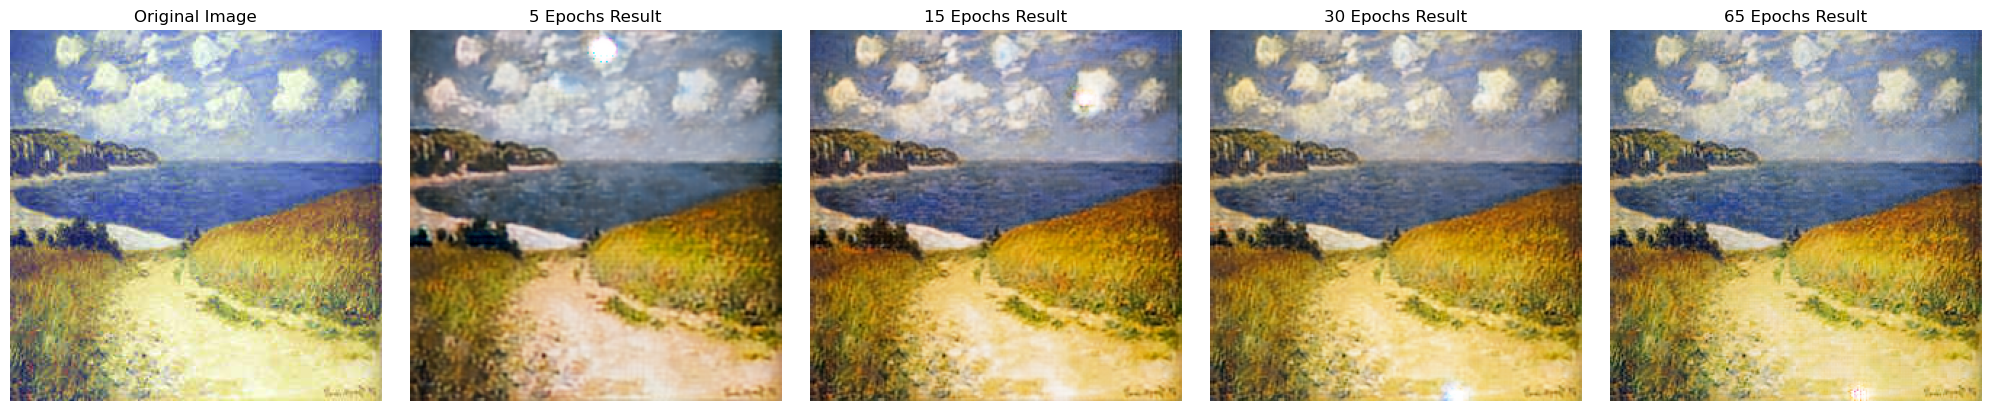

In [16]:
test_image_x = m2p_test_dataset[1][0].numpy()
test_models(test_image_x, models, titles)

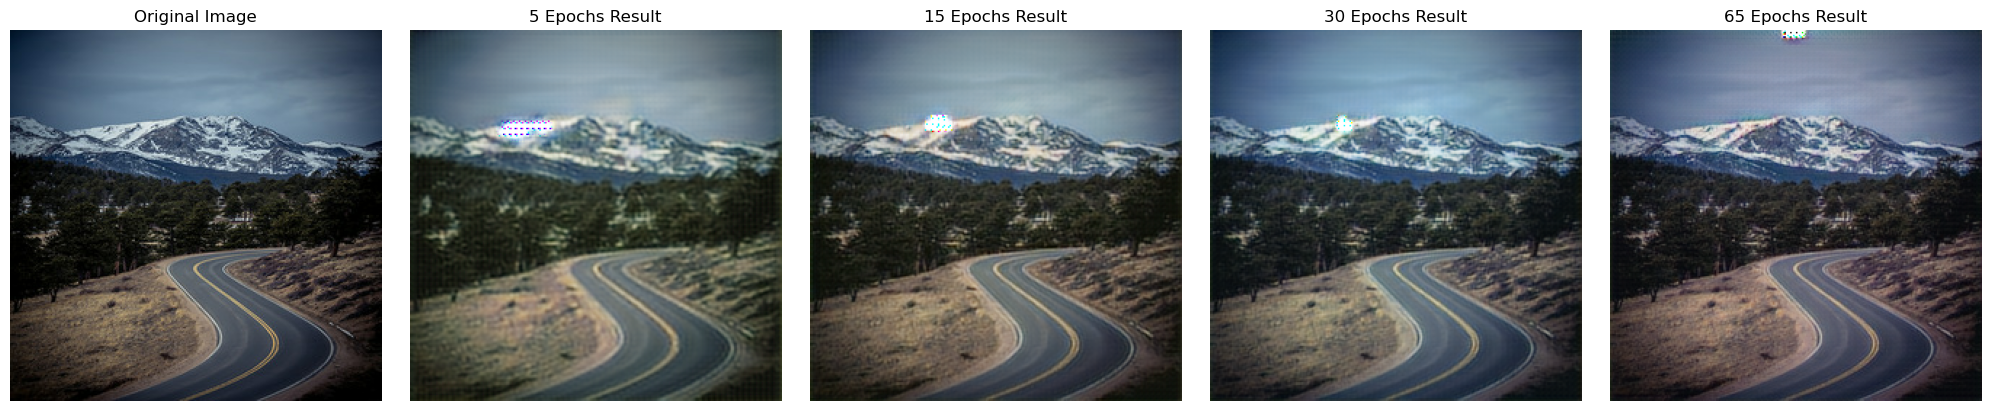

In [17]:
test_image_y = m2p_test_dataset[0][1].numpy()
test_models(test_image_y, models, titles, False)

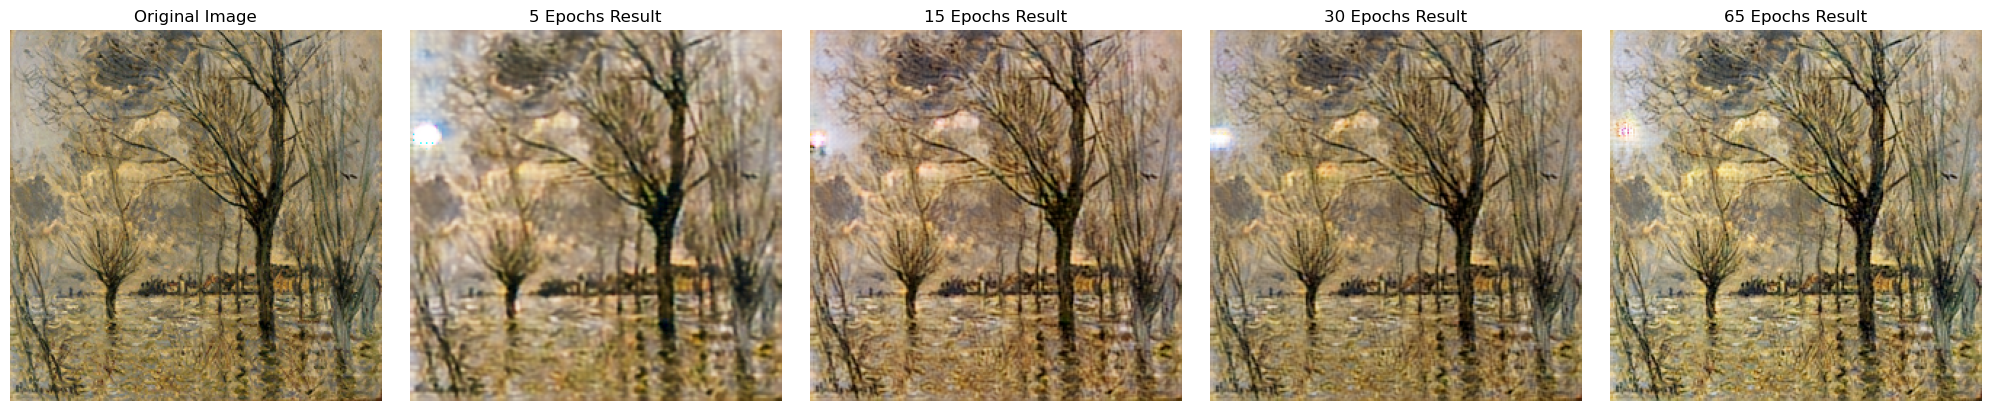

In [18]:
test_image_x = m2p_test_dataset[10][0].numpy()
test_models(test_image_x, models, titles)

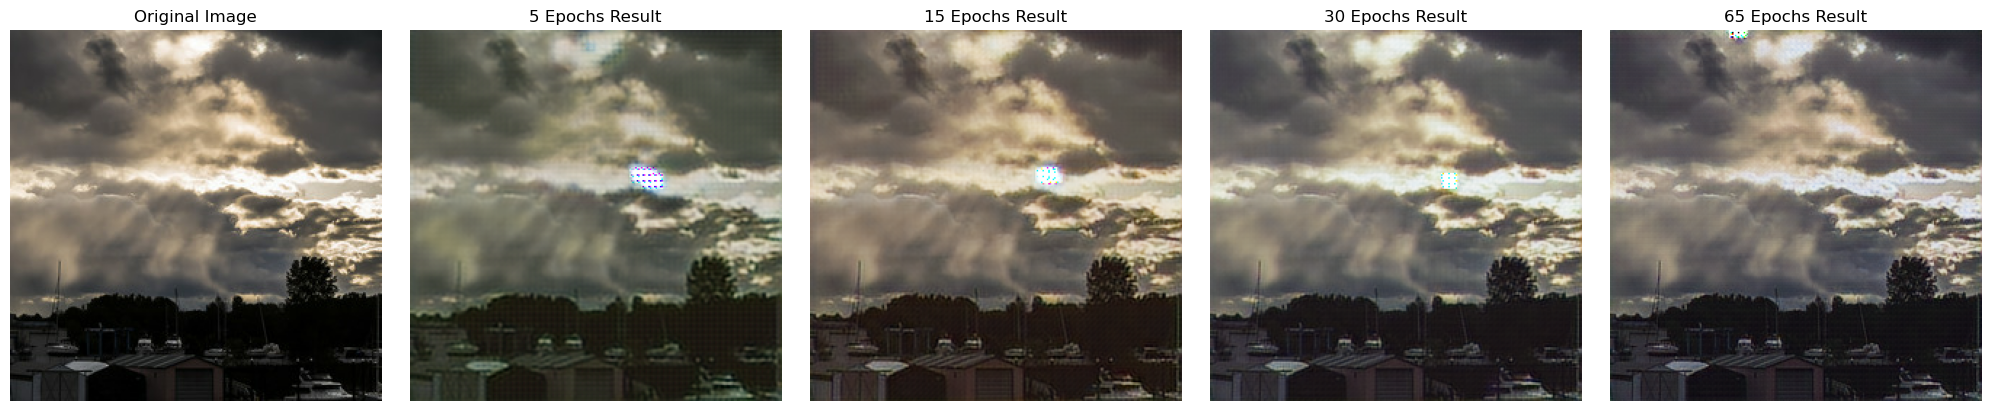

In [19]:
test_image_y = m2p_test_dataset[10][1].numpy()
test_models(test_image_y, models, titles, False)